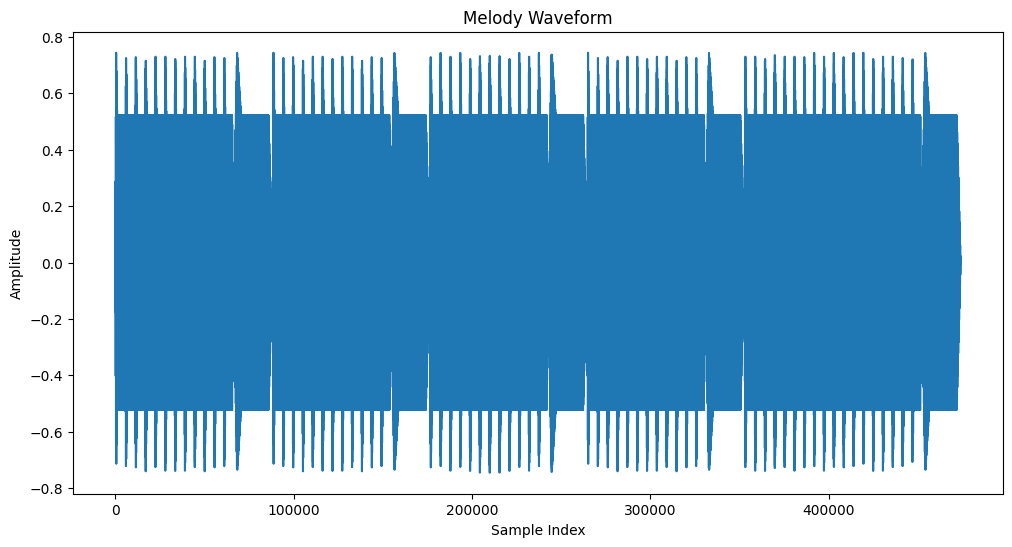

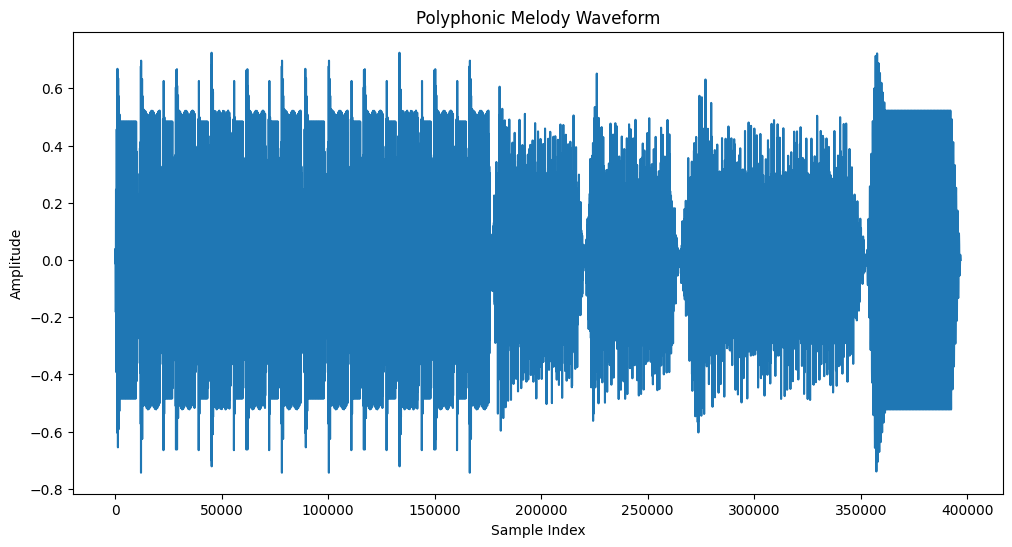

In [ ]:
# Date: 2025-01-27
# Final project might be heavily related to this. e.g., digital piano in Python using keyboard or some other controller interface

# Note: Can take 10-20 seconds to finish running the program (due to writing .wav files and generating plots)

# --- Required Packages (4)-------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # For showing multiple waveform graphs 
import wave
import struct


# --- Helper Functions (4)---------------------------------------------------------

def midi2freq(midi_note: int) -> float:
    """
    Convert MIDI note number to frequency in Hz.
    MIDI note 69 corresponds to A4 (440 Hz).
    """
    # MIDI note 69 corresponds to 440Hz (A4), and each note is 1.05946 times the frequency of the previous note
    freq = 440.0 * (2 ** ((midi_note - 69) / 12.0))
    return freq

def generate_triangle(midi_note: int, duration: float, num_sinusoids: int) -> np.ndarray:
    """
    Generate a triangle wave signal based on MIDI note number, duration, and number of sinusoids.
    Args:
        midi_note (int): The MIDI note number.
        duration (float): Duration of the note in seconds.
        num_sinusoids (int): Number of sinusoids to sum for the triangle wave approximation.
    Returns:
        np.ndarray: The generated triangle wave signal at audio rate.
    """
    freq = midi2freq(midi_note)
    sample_rate = 44100  # Audio sample rate
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Generate the triangle wave by summing the sinusoids (Fourier series)
    triangle_wave = np.zeros_like(t)
    for n in range(1, num_sinusoids + 1, 2):  # Sum only odd harmonics
        triangle_wave += (1 / n**2) * np.sin(2 * np.pi * n * freq * t)
    
    triangle_wave *= 8 / np.pi**2  # Normalize the triangle wave amplitude
    return triangle_wave

def generate_adsr_envelope(duration: float, attack = 0.1, decay = 0.1, sustain = 0.7, release = 0.1) -> np.ndarray:
    """
    Generate an ADSR envelope to apply to the generated sound.
    Args:
        duration (float): Duration of the note in seconds.
        attack (float): Attack time as a fraction of the total duration.
        decay (float): Decay time as a fraction of the total duration.
        sustain (float): Sustain level as a percentage of max amplitude.
        release (float): Release time as a fraction of the total duration.
    Returns:
        np.ndarray: The generated ADSR envelope signal.
    """
    sample_rate = 44100  # Standard Audio sample rate (44.1kHz)
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False) # Time range t
    
    # Calculate the time points for each phase of the ADSR envelope
    attack_end = int(attack * len(t))
    decay_end = int((attack + decay) * len(t))
    release_start = len(t) - int(release * len(t))

    envelope = np.zeros_like(t)
    
    # Attack phase
    envelope[:attack_end] = np.linspace(0, 1, attack_end)
    
    # Decay phase
    envelope[attack_end:decay_end] = np.linspace(1, sustain, decay_end - attack_end)
    
    # Sustain phase
    envelope[decay_end:release_start] = sustain
    
    # Release phase
    envelope[release_start:] = np.linspace(sustain, 0, len(t) - release_start)
    
    return envelope

def apply_envelope(signal: np.ndarray, envelope: np.ndarray) -> np.ndarray:
    """
    Apply the given ADSR envelope to the generated signal.
    Args:
        signal (np.ndarray): The generated signal (triangle or sine wave).
        envelope (np.ndarray): The ADSR envelope to apply.
    Returns:
        np.ndarray: The signal with the ADSR envelope applied.
    """
    return signal * envelope



# --- Melody Rendering (3)----------------------------------------------------------

def render_melody(notes: list[tuple[int, float]], envelope = False, num_sinusoids = 10) -> np.array:
    """
    Render a simple melody as an audio waveform.
    Args:
        notes (list of tuples): List of (midi_note, duration) tuples for the melody.
        envelope (bool): Whether to apply the ADSR envelope to each note.
        num_sinusoids (int): Number of sinusoids to use for triangle wave generation.
    Returns:
        np.ndarray: The rendered melody waveform.
    """
    melody = np.array([])
    for midi_note, duration in notes:
        # Generate triangle wave (or sine wave) for the note
        note_signal = generate_triangle(midi_note, duration, num_sinusoids)
        
        # Apply ADSR envelope if needed
        if envelope:
            adsr = generate_adsr_envelope(duration)
            note_signal = apply_envelope(note_signal, adsr)
        
        melody = np.concatenate((melody, note_signal))
    
    return melody

def polyphonic_melody(chords: list[list[tuple[int, float]]], envelope=False, num_sinusoids=10) -> np.ndarray:
    """
    Render a polyphonic melody with multiple notes played simultaneously.

    Args:
        chords (list of lists of tuples):
            List of chords, where each chord is a list of (midi_note, duration) tuples.
        envelope (bool):
            Whether to apply the ADSR envelope to each note.
        num_sinusoids (int):
            Number of sinusoids to use for triangle wave generation.

    Returns:
        np.ndarray: The rendered polyphonic melody waveform.
    """
    sample_rate = 44100  # Audio sample rate
    full_melody = np.array([])

    for chord in chords:
        # Determine the maximum duration of the notes in the chord
        max_duration = max(note[1] for note in chord)
        t = np.linspace(0, max_duration, int(sample_rate * max_duration), endpoint=False)

        # Generate and mix the signals for all notes in the chord
        chord_signal = np.zeros_like(t)
        for midi_note, duration in chord:
            note_signal = generate_triangle(midi_note, duration, num_sinusoids)

            # Apply ADSR envelope if enabled
            if envelope:
                adsr = generate_adsr_envelope(duration)
                note_signal = apply_envelope(note_signal, adsr)

            # Pad note signal to match the chord length and add to chord signal
            padded_note = np.pad(note_signal, (0, len(t) - len(note_signal)), mode='constant')
            chord_signal += padded_note

        # Normalize the chord signal to prevent clipping
        chord_signal /= len(chord)

        # Append the chord signal to the full melody
        full_melody = np.concatenate((full_melody, chord_signal))

    return full_melody

def save_wav(filename: str, signal: np.ndarray) -> None:
    """
    Save the generated signal as a .wav file.
    Args:
        filename (str): Name of the output .wav file.
        signal (np.ndarray): The signal to save.
    """
    sample_rate = 44100  # Audio sample rate
    signal = np.int16(signal / np.max(np.abs(signal)) * 32767)  # Normalize to int16 range
    
    with wave.open(filename, 'w') as wav_file:
        wav_file.setnchannels(1)  # Mono audio
        wav_file.setsampwidth(2)  # 16-bit samples
        wav_file.setframerate(sample_rate)
        for sample in signal:
            wav_file.writeframes(struct.pack('h', sample))


# --- Main (1) -----------------------------------------------------------

if __name__ == "__main__":
    # Define melody notes as (MIDI note, duration in seconds)
    melody_notes = [
        # Minor 12-Bar Blues
        (60, 0.125), (63, 0.125), (65, 0.125), (66, 0.125), # C-minor
        (67, 0.125), (70, 0.125), (72, 0.125), (70, 0.125),
        (67, 0.125), (66, 0.125), (65, 0.125), (63, 0.125),
        (60, 0.5),

        (60, 0.125), (63, 0.125), (65, 0.125), (66, 0.125), # C-minor 
        (67, 0.125), (70, 0.125), (72, 0.125), (70, 0.125),
        (67, 0.125), (66, 0.125), (65, 0.125), (63, 0.125),
        (60, 0.5),

        (65, 0.125), (68, 0.125), (70, 0.125), (71, 0.125), # F-minor  
        (72, 0.125), (75, 0.125), (77, 0.125), (75, 0.125),
        (72, 0.125), (71, 0.125), (70, 0.125), (68, 0.125),
        (65, 0.5),

        (60, 0.125), (63, 0.125), (65, 0.125), (66, 0.125), # C-minor 
        (67, 0.125), (70, 0.125), (72, 0.125), (70, 0.125),
        (67, 0.125), (66, 0.125), (65, 0.125), (63, 0.125),
        (60, 0.5),

        (67, 0.125), (70, 0.125), (72, 0.125), (67, 0.125), # G-minor 
        (70, 0.125), (72, 0.125), (67, 0.125), (70, 0.125),
        
        (65, 0.125), (68, 0.125), (70, 0.125), (67, 0.125), # F-minor  
        (68, 0.125), (70, 0.125), (68, 0.125), (70, 0.125), 

        (60, 0.125), (72, 0.125), (70, 0.125),              # C-minor
        (67, 0.125), (63, 0.125), (58, 0.125),
        (60, 0.25)
    ]

    # Define polyphonic_notes as lists of (MIDI note, duration in seconds) which represent notes, intervals, or chords
    polyphonic_notes = [
        # Riff: C Dorian
        [(48, 0.25), (60, 0.25)],
        [(63, 0.25), (67, 0.25)],
        [(48, 0.125), (60, 0.125)],
        [(65, 0.25), (69, 0.25)], 
        [(48, 0.125), (60, 0.125)],
        [(67, 0.25), (70, 0.25)],
        [(48, 0.125), (60, 0.125)],
        [(65, 0.25), (69, 0.25)],
        [(48, 0.125), (60, 0.125)],
        [(63, 0.25), (67, 0.25)],
        # Repeat
        [(48, 0.25), (60, 0.25)],
        [(63, 0.25), (67, 0.25)],
        [(48, 0.125), (60, 0.125)],
        [(65, 0.25), (69, 0.25)], 
        [(48, 0.125), (60, 0.125)],
        [(67, 0.25), (70, 0.25)],
        [(48, 0.125), (60, 0.125)],
        [(65, 0.25), (69, 0.25)],
        [(48, 0.125), (60, 0.125)],
        [(63, 0.25), (67, 0.25)],
        # End Cadence: ii-V-i 
        [(26, 1.0), (62, 1.0), (65, 1.0), (68, 1.0), (72, 1.0)],    # D half-diminished chord
        [(28, 1.0), (59, 1.0), (62, 1.0), (65, 1.0), (70, 1.0)],    # G7 add #9 chord
        [(24, 2.0), (58, 2.0), (60, 2.0), (63, 2.0), (67, 2.0)],    # Cmin9
        [(36, 1.0)]                                                 # end on root C
    ]

    # Generate the melody and polyphonic melody
    melody = render_melody(melody_notes, envelope=True, num_sinusoids=10)
    polyphonic = polyphonic_melody(polyphonic_notes, envelope=True, num_sinusoids=10)

    # Save the waveforms to .wav files
    save_wav("melody.wav", melody)
    save_wav("polyphonic_melody.wav", polyphonic)

    # Generate waveforms
    melody_waveform = render_melody(melody_notes, envelope=True)
    polyphonic_waveform = polyphonic_melody(polyphonic_notes, envelope=True)

    # Plot melody waveform
    plt.figure(figsize=(12, 6))
    plt.plot(melody_waveform[:])
    plt.title("Melody Waveform")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    display(plt.gcf())  # Display the melody plot
    plt.close()

    # Plot polyphonic melody waveform
    plt.figure(figsize=(12, 6))
    plt.plot(polyphonic_waveform[:])
    plt.title("Polyphonic Melody Waveform")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    display(plt.gcf())  # Display the polyphonic melody plot
    plt.close()